### Experiment: Normalization

**Question**: Is normalization necessary? If so, what kind performs best?

**Hypothesis**: The data is already re-referenced using `mne.set_eeg_reference("average")` during pre-processing. The range used is approximately $[-55, 55]$, models might work better at a more commonly used range of $[0,1]$, or $[-1, 1]$ to keep negative numbers.

**Result**:

#### Part 1: Investigation

In [1]:
import xarray as xr
from xhistogram.xarray import histogram
import numpy as np
from pathlib import Path

In [2]:
data_path = Path("../data/sat1/split_stage_data.nc")
data = xr.load_dataset(data_path)

##### Histogram of distribution of all values

<xarray.DataArray 'histogram_data' (data_bin: 59)>
array([      3,       2,       2,       4,       8,       7,      12,
            26,      27,      39,      55,      98,     114,     172,
           263,     443,     762,    1349,    2375,    4173,    7773,
         14373,   26982,   49882,   92770,  170517,  310136,  540673,
        888553, 1317833, 1660741, 1691973, 1387367,  953905,  584410,
        337334,  189053,  105587,   59302,   33381,   19463,   11398,
          6749,    3942,    2344,    1453,     898,     504,     286,
           204,     119,      77,      30,      34,      18,      14,
             6,       0,       2])
Coordinates:
  * data_bin  (data_bin) float64 -60.61 -58.63 -56.65 ... 50.32 52.3 54.28

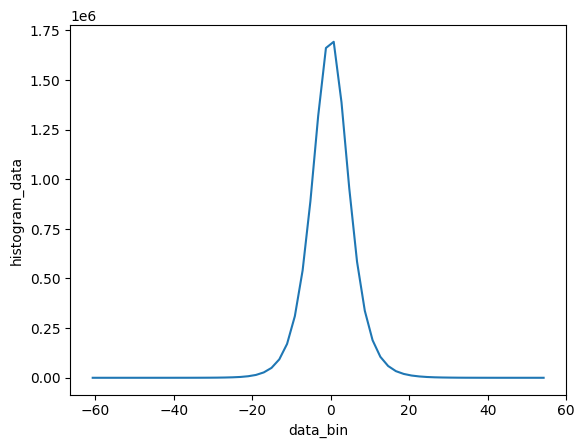

In [3]:
max = data.max().data.item()
min = data.min().data.item()
bins = np.linspace(min, max, 60)
hist = histogram(data.data, bins=bins, block_size=data.samples.size)
display(hist)
hist.plot()

##### Histogram of distribution for each channel

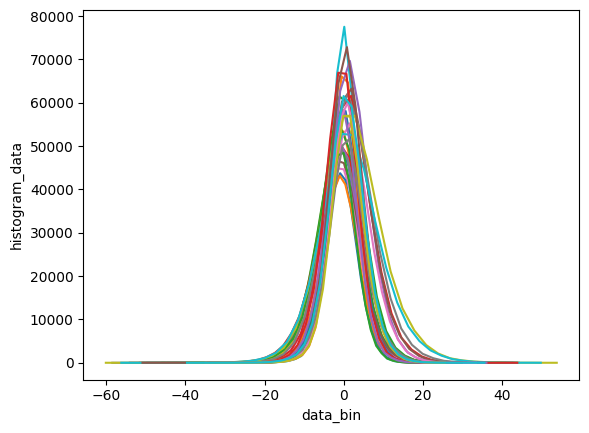

In [4]:
for channel in data.channels:
    data_subset = data.sel(channels=channel)
    max = data_subset.max().data.item()
    min = data_subset.min().data.item()
    bins = np.linspace(min, max, 40)
    hist = histogram(data_subset.data, bins=bins, block_size=data_subset.samples.size)
    hist.plot()

#### Part 2: Experiment

In [1]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import xarray as xr
from hmpai.utilities import print_results
from hmpai.pytorch.models import *
from hmpai.pytorch.training import k_fold_cross_validate
from hmpai.normalization import *

In [2]:
data_path = Path("../data/sat1/split_stage_data.nc")

data = xr.load_dataset(data_path)

In [3]:
norm_fns = [norm_dummy, norm_0_to_1, norm_min1_to_1]


def test_normalization(norm_fn, seed):
    print(f"Testing norm_fn: {norm_fn.__name__}")
    model = SAT1GRU
    model_kwargs = {
        "n_channels": len(data.channels),
        "n_samples": len(data.samples),
        "n_classes": len(data.labels),
    }
    train_kwargs = {
        "logs_path": Path("../logs/exp_normalization_rng/"),
        "additional_info": {"norm_fn": norm_fn.__name__},
        "additional_name": f"norm_fn-{norm_fn.__name__}",
    }
    result = k_fold_cross_validate(
        model,
        model_kwargs,
        data,
        k=25,
        normalization_fn=norm_fn,
        train_kwargs=train_kwargs,
        seed=seed,
    )
    print_results(result)

In [4]:
test_normalization(norm_fns[0], 43)

Testing norm_fn: norm_dummy
Fold 1: test fold: ['0007']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 1: Accuracy: 0.8978102189781022
Fold 1: F1-Score: 0.8962024452420394
Fold 2: test fold: ['0011']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 2: Accuracy: 0.9171741778319124
Fold 2: F1-Score: 0.9158331518732006
Fold 3: test fold: ['0006']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 3: Accuracy: 0.9106918238993711
Fold 3: F1-Score: 0.9068756384143709
Fold 4: test fold: ['0014']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 4: Accuracy: 0.9159120310478654
Fold 4: F1-Score: 0.9160599090619433
Fold 5: test fold: ['0025']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 5: Accuracy: 0.9160493827160494
Fold 5: F1-Score: 0.9196190135630389
Fold 6: test fold: ['0016']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 6: Accuracy: 0.8933177022274326
Fold 6: F1-Score: 0.8927783184010425
Fold 7: test fold: ['0009']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 7: Accuracy: 0.9228110599078341
Fold 7: F1-Score: 0.9237152567339242
Fold 8: test fold: ['0013']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 8: Accuracy: 0.931119311193112
Fold 8: F1-Score: 0.9325586317327245
Fold 9: test fold: ['0012']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 9: Accuracy: 0.9445812807881774
Fold 9: F1-Score: 0.9470854554893282
Fold 10: test fold: ['0002']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 10: Accuracy: 0.899188876013905
Fold 10: F1-Score: 0.8898311284125873
Fold 11: test fold: ['0010']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 11: Accuracy: 0.8773006134969326
Fold 11: F1-Score: 0.8830300001627542
Fold 12: test fold: ['0019']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 12: Accuracy: 0.9637681159420289
Fold 12: F1-Score: 0.9624666011435119
Fold 13: test fold: ['0004']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 13: Accuracy: 0.8865546218487395
Fold 13: F1-Score: 0.8870753831847449
Fold 14: test fold: ['0024']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 14: Accuracy: 0.8432147562582345
Fold 14: F1-Score: 0.8469039437961537
Fold 15: test fold: ['0008']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 15: Accuracy: 0.9177545691906005
Fold 15: F1-Score: 0.9113260535758501
Fold 16: test fold: ['0021']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 16: Accuracy: 0.9547619047619048
Fold 16: F1-Score: 0.9515322695506742
Fold 17: test fold: ['0015']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 17: Accuracy: 0.8965116279069767
Fold 17: F1-Score: 0.8928732968934536
Fold 18: test fold: ['0003']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 18: Accuracy: 0.9399249061326659
Fold 18: F1-Score: 0.9401796286832396
Fold 19: test fold: ['0023']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 19: Accuracy: 0.9460093896713615
Fold 19: F1-Score: 0.9415078652446773
Fold 20: test fold: ['0020']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 20: Accuracy: 0.8941176470588236
Fold 20: F1-Score: 0.8929835003658269
Fold 21: test fold: ['0017']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 21: Accuracy: 0.8808664259927798
Fold 21: F1-Score: 0.869295782638247
Fold 22: test fold: ['0022']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 22: Accuracy: 0.9193357058125742
Fold 22: F1-Score: 0.9163120789697299
Fold 23: test fold: ['0018']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 23: Accuracy: 0.9356796116504854
Fold 23: F1-Score: 0.9378699092766183
Fold 24: test fold: ['0001']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 24: Accuracy: 0.9265402843601895
Fold 24: F1-Score: 0.9203372080814777
Fold 25: test fold: ['0005']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 25: Accuracy: 0.9525547445255474
Fold 25: F1-Score: 0.9521251699295945
Average Accuracy: 0.9153420315685442
Average F1-Score: 0.91385510561683


In [5]:
test_normalization(norm_fns[1], 43)

Testing norm_fn: norm_0_to_1
Fold 1: test fold: ['0007']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 1: Accuracy: 0.9209245742092458
Fold 1: F1-Score: 0.9188992299594076
Fold 2: test fold: ['0011']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 2: Accuracy: 0.9171741778319124
Fold 2: F1-Score: 0.9188997517331291
Fold 3: test fold: ['0006']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 3: Accuracy: 0.9119496855345912
Fold 3: F1-Score: 0.9096264020966567
Fold 4: test fold: ['0014']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 4: Accuracy: 0.9391979301423027
Fold 4: F1-Score: 0.9375015845554516
Fold 5: test fold: ['0025']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 5: Accuracy: 0.9407407407407408
Fold 5: F1-Score: 0.9444338419924263
Fold 6: test fold: ['0016']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 6: Accuracy: 0.8933177022274326
Fold 6: F1-Score: 0.8955041814556411
Fold 7: test fold: ['0009']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 7: Accuracy: 0.9389400921658986
Fold 7: F1-Score: 0.9407688687902904
Fold 8: test fold: ['0013']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 8: Accuracy: 0.9274292742927429
Fold 8: F1-Score: 0.9318906338129012
Fold 9: test fold: ['0012']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 9: Accuracy: 0.9298029556650246
Fold 9: F1-Score: 0.9329178011985476
Fold 10: test fold: ['0002']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 10: Accuracy: 0.9200463499420626
Fold 10: F1-Score: 0.9153703295580351
Fold 11: test fold: ['0010']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 11: Accuracy: 0.9067484662576687
Fold 11: F1-Score: 0.911448769554366
Fold 12: test fold: ['0019']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 12: Accuracy: 0.9685990338164251
Fold 12: F1-Score: 0.9671155241045906
Fold 13: test fold: ['0004']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 13: Accuracy: 0.9229691876750701
Fold 13: F1-Score: 0.9263462746691415
Fold 14: test fold: ['0024']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 14: Accuracy: 0.8682476943346509
Fold 14: F1-Score: 0.8727854630707924
Fold 15: test fold: ['0008']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 15: Accuracy: 0.9608355091383812
Fold 15: F1-Score: 0.9611752789445746
Fold 16: test fold: ['0021']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 16: Accuracy: 0.944047619047619
Fold 16: F1-Score: 0.9415172457059313
Fold 17: test fold: ['0015']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 17: Accuracy: 0.9255813953488372
Fold 17: F1-Score: 0.9247158235914839
Fold 18: test fold: ['0003']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 18: Accuracy: 0.9637046307884856
Fold 18: F1-Score: 0.963567349898357
Fold 19: test fold: ['0023']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 19: Accuracy: 0.9471830985915493
Fold 19: F1-Score: 0.9450776865258955
Fold 20: test fold: ['0020']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 20: Accuracy: 0.9254901960784314
Fold 20: F1-Score: 0.9273370396737354
Fold 21: test fold: ['0017']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 21: Accuracy: 0.9085439229843562
Fold 21: F1-Score: 0.9038788356666462
Fold 22: test fold: ['0022']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 22: Accuracy: 0.9359430604982206
Fold 22: F1-Score: 0.9367850213514674
Fold 23: test fold: ['0018']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 23: Accuracy: 0.9223300970873787
Fold 23: F1-Score: 0.9246641340510487
Fold 24: test fold: ['0001']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 24: Accuracy: 0.9407582938388626
Fold 24: F1-Score: 0.9409970101412988
Fold 25: test fold: ['0005']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 25: Accuracy: 0.9562043795620438
Fold 25: F1-Score: 0.955041726695703
Average Accuracy: 0.9294684027119975
Average F1-Score: 0.9299306323519009


In [6]:
test_normalization(norm_fns[2], 43)

Testing norm_fn: norm_min1_to_1
Fold 1: test fold: ['0007']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 1: Accuracy: 0.9197080291970803
Fold 1: F1-Score: 0.9173365489339194
Fold 2: test fold: ['0011']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 2: Accuracy: 0.9354445797807551
Fold 2: F1-Score: 0.9369129648665847
Fold 3: test fold: ['0006']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 3: Accuracy: 0.9069182389937107
Fold 3: F1-Score: 0.9031208403535936
Fold 4: test fold: ['0014']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 4: Accuracy: 0.9404915912031048
Fold 4: F1-Score: 0.9411232093269852
Fold 5: test fold: ['0025']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 5: Accuracy: 0.9419753086419753
Fold 5: F1-Score: 0.9450355473379561
Fold 6: test fold: ['0016']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 6: Accuracy: 0.902696365767878
Fold 6: F1-Score: 0.9038827215204102
Fold 7: test fold: ['0009']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 7: Accuracy: 0.9447004608294931
Fold 7: F1-Score: 0.9468037694454681
Fold 8: test fold: ['0013']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 8: Accuracy: 0.9434194341943419
Fold 8: F1-Score: 0.9465958590702659
Fold 9: test fold: ['0012']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 9: Accuracy: 0.9458128078817734
Fold 9: F1-Score: 0.9491784414779927
Fold 10: test fold: ['0002']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 10: Accuracy: 0.9212050984936269
Fold 10: F1-Score: 0.9131686445138548
Fold 11: test fold: ['0010']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 11: Accuracy: 0.9153374233128835
Fold 11: F1-Score: 0.9196214206383697
Fold 12: test fold: ['0019']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 12: Accuracy: 0.9722222222222222
Fold 12: F1-Score: 0.9722977100760403
Fold 13: test fold: ['0004']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 13: Accuracy: 0.9173669467787114
Fold 13: F1-Score: 0.9213367399085353
Fold 14: test fold: ['0024']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 14: Accuracy: 0.8880105401844532
Fold 14: F1-Score: 0.8884073862675983
Fold 15: test fold: ['0008']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 15: Accuracy: 0.9595300261096605
Fold 15: F1-Score: 0.9603357522964184
Fold 16: test fold: ['0021']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 16: Accuracy: 0.9678571428571429
Fold 16: F1-Score: 0.9666563640355406
Fold 17: test fold: ['0015']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 17: Accuracy: 0.9209302325581395
Fold 17: F1-Score: 0.9165952886832374
Fold 18: test fold: ['0003']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 18: Accuracy: 0.951188986232791
Fold 18: F1-Score: 0.9529576692634668
Fold 19: test fold: ['0023']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 19: Accuracy: 0.9706572769953051
Fold 19: F1-Score: 0.9688444731068984
Fold 20: test fold: ['0020']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 20: Accuracy: 0.9006535947712418
Fold 20: F1-Score: 0.9017191375041392
Fold 21: test fold: ['0017']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 21: Accuracy: 0.9229843561973526
Fold 21: F1-Score: 0.9181137043344414
Fold 22: test fold: ['0022']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 22: Accuracy: 0.9371293001186239
Fold 22: F1-Score: 0.9346986406907394
Fold 23: test fold: ['0018']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 23: Accuracy: 0.9441747572815534
Fold 23: F1-Score: 0.9447862928001978
Fold 24: test fold: ['0001']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 24: Accuracy: 0.9466824644549763
Fold 24: F1-Score: 0.9417351938838197
Fold 25: test fold: ['0005']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 25: Accuracy: 0.9598540145985401
Fold 25: F1-Score: 0.9600900744657286
Average Accuracy: 0.9350780479862937
Average F1-Score: 0.934854175792088


In [7]:
test_normalization(norm_fns[0], 44)

Testing norm_fn: norm_dummy
Fold 1: test fold: ['0020']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 1: Accuracy: 0.8588235294117647
Fold 1: F1-Score: 0.8583641017476251
Fold 2: test fold: ['0003']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 2: Accuracy: 0.9461827284105131
Fold 2: F1-Score: 0.9429547444596628
Fold 3: test fold: ['0012']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 3: Accuracy: 0.9322660098522167
Fold 3: F1-Score: 0.9321008373482472
Fold 4: test fold: ['0002']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 4: Accuracy: 0.8852838933951332
Fold 4: F1-Score: 0.8751831228842267
Fold 5: test fold: ['0005']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 5: Accuracy: 0.9440389294403893
Fold 5: F1-Score: 0.9442319324566568
Fold 6: test fold: ['0006']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 6: Accuracy: 0.8905660377358491
Fold 6: F1-Score: 0.8896164586029316
Fold 7: test fold: ['0013']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 7: Accuracy: 0.939729397293973
Fold 7: F1-Score: 0.940752299226458
Fold 8: test fold: ['0023']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 8: Accuracy: 0.9518779342723005
Fold 8: F1-Score: 0.9473236318953673
Fold 9: test fold: ['0017']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 9: Accuracy: 0.8916967509025271
Fold 9: F1-Score: 0.882511888152456
Fold 10: test fold: ['0022']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 10: Accuracy: 0.9395017793594306
Fold 10: F1-Score: 0.9385331724719359
Fold 11: test fold: ['0019']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 11: Accuracy: 0.9734299516908212
Fold 11: F1-Score: 0.9711311540147296
Fold 12: test fold: ['0010']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 12: Accuracy: 0.8895705521472392
Fold 12: F1-Score: 0.8940270029797244
Fold 13: test fold: ['0007']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 13: Accuracy: 0.9075425790754258
Fold 13: F1-Score: 0.9080241359521215
Fold 14: test fold: ['0015']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 14: Accuracy: 0.8906976744186047
Fold 14: F1-Score: 0.8849472024872813
Fold 15: test fold: ['0008']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 15: Accuracy: 0.9295039164490861
Fold 15: F1-Score: 0.9302470282361661
Fold 16: test fold: ['0009']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 16: Accuracy: 0.9182027649769585
Fold 16: F1-Score: 0.918902747155153
Fold 17: test fold: ['0011']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 17: Accuracy: 0.9208282582216809
Fold 17: F1-Score: 0.9192551466669008
Fold 18: test fold: ['0016']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 18: Accuracy: 0.8933177022274326
Fold 18: F1-Score: 0.8949952432663008
Fold 19: test fold: ['0025']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 19: Accuracy: 0.917283950617284
Fold 19: F1-Score: 0.9213432399803594
Fold 20: test fold: ['0001']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 20: Accuracy: 0.943127962085308
Fold 20: F1-Score: 0.9408207975349901
Fold 21: test fold: ['0024']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 21: Accuracy: 0.8682476943346509
Fold 21: F1-Score: 0.8685894969319975
Fold 22: test fold: ['0014']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 22: Accuracy: 0.9120310478654593
Fold 22: F1-Score: 0.9149683696663651
Fold 23: test fold: ['0018']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 23: Accuracy: 0.9223300970873787
Fold 23: F1-Score: 0.92107725413864
Fold 24: test fold: ['0004']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 24: Accuracy: 0.8921568627450981
Fold 24: F1-Score: 0.8938127408671519
Fold 25: test fold: ['0021']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 25: Accuracy: 0.9452380952380952
Fold 25: F1-Score: 0.9406610024508147
Average Accuracy: 0.9161390439701849
Average F1-Score: 0.9149749900629703


In [8]:
test_normalization(norm_fns[1], 44)

Testing norm_fn: norm_0_to_1
Fold 1: test fold: ['0020']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 1: Accuracy: 0.9137254901960784
Fold 1: F1-Score: 0.9122044849472424
Fold 2: test fold: ['0003']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 2: Accuracy: 0.9486858573216521
Fold 2: F1-Score: 0.9498777788944054
Fold 3: test fold: ['0012']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 3: Accuracy: 0.9433497536945813
Fold 3: F1-Score: 0.9460996412989564
Fold 4: test fold: ['0002']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 4: Accuracy: 0.8910776361529548
Fold 4: F1-Score: 0.8812944229984152
Fold 5: test fold: ['0005']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 5: Accuracy: 0.9549878345498783
Fold 5: F1-Score: 0.9547412742574368
Fold 6: test fold: ['0006']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 6: Accuracy: 0.8981132075471698
Fold 6: F1-Score: 0.8978000535845154
Fold 7: test fold: ['0013']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 7: Accuracy: 0.9200492004920049
Fold 7: F1-Score: 0.9247980461593526
Fold 8: test fold: ['0023']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 8: Accuracy: 0.9647887323943662
Fold 8: F1-Score: 0.9630482763323739
Fold 9: test fold: ['0017']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 9: Accuracy: 0.9049338146811071
Fold 9: F1-Score: 0.9005962859495522
Fold 10: test fold: ['0022']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 10: Accuracy: 0.9371293001186239
Fold 10: F1-Score: 0.9388127374420803
Fold 11: test fold: ['0019']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 11: Accuracy: 0.9746376811594203
Fold 11: F1-Score: 0.9755040431417656
Fold 12: test fold: ['0010']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 12: Accuracy: 0.9226993865030675
Fold 12: F1-Score: 0.9263267406400907
Fold 13: test fold: ['0007']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 13: Accuracy: 0.9318734793187348
Fold 13: F1-Score: 0.9321892653530099
Fold 14: test fold: ['0015']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 14: Accuracy: 0.9127906976744186
Fold 14: F1-Score: 0.9109142856423296
Fold 15: test fold: ['0008']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 15: Accuracy: 0.9530026109660574
Fold 15: F1-Score: 0.9527293811791356
Fold 16: test fold: ['0009']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 16: Accuracy: 0.9412442396313364
Fold 16: F1-Score: 0.9402966553518002
Fold 17: test fold: ['0011']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 17: Accuracy: 0.9135200974421437
Fold 17: F1-Score: 0.914913422313832
Fold 18: test fold: ['0016']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 18: Accuracy: 0.8886283704572099
Fold 18: F1-Score: 0.888536956908793
Fold 19: test fold: ['0025']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 19: Accuracy: 0.9234567901234568
Fold 19: F1-Score: 0.9253628225436824
Fold 20: test fold: ['0001']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 20: Accuracy: 0.9372037914691943
Fold 20: F1-Score: 0.9352296917400842
Fold 21: test fold: ['0024']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 21: Accuracy: 0.8656126482213439
Fold 21: F1-Score: 0.8679071997654184
Fold 22: test fold: ['0014']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 22: Accuracy: 0.9133247089262613
Fold 22: F1-Score: 0.9149139730072632
Fold 23: test fold: ['0018']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 23: Accuracy: 0.933252427184466
Fold 23: F1-Score: 0.9341154848413845
Fold 24: test fold: ['0004']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 24: Accuracy: 0.9229691876750701
Fold 24: F1-Score: 0.9251443621198522
Fold 25: test fold: ['0021']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 25: Accuracy: 0.955952380952381
Fold 25: F1-Score: 0.9548991398185318
Average Accuracy: 0.9266803729941192
Average F1-Score: 0.9267302570492523


In [9]:
test_normalization(norm_fns[2], 44)

Testing norm_fn: norm_min1_to_1
Fold 1: test fold: ['0020']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 1: Accuracy: 0.9058823529411765
Fold 1: F1-Score: 0.9066928618890222
Fold 2: test fold: ['0003']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 2: Accuracy: 0.9699624530663329
Fold 2: F1-Score: 0.9701256814389649
Fold 3: test fold: ['0012']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 3: Accuracy: 0.9482758620689655
Fold 3: F1-Score: 0.9497734290140091
Fold 4: test fold: ['0002']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 4: Accuracy: 0.9154113557358053
Fold 4: F1-Score: 0.9085659016387899
Fold 5: test fold: ['0005']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 5: Accuracy: 0.9598540145985401
Fold 5: F1-Score: 0.9616225482410534
Fold 6: test fold: ['0006']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 6: Accuracy: 0.9144654088050315
Fold 6: F1-Score: 0.9152232507004652
Fold 7: test fold: ['0013']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 7: Accuracy: 0.9458794587945879
Fold 7: F1-Score: 0.9481367981511909
Fold 8: test fold: ['0023']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 8: Accuracy: 0.9694835680751174
Fold 8: F1-Score: 0.9667204949723736
Fold 9: test fold: ['0017']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 9: Accuracy: 0.9133574007220217
Fold 9: F1-Score: 0.9060279123968169
Fold 10: test fold: ['0022']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 10: Accuracy: 0.9252669039145908
Fold 10: F1-Score: 0.9252712463769963
Fold 11: test fold: ['0019']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 11: Accuracy: 0.966183574879227
Fold 11: F1-Score: 0.965156222968752
Fold 12: test fold: ['0010']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 12: Accuracy: 0.9079754601226994
Fold 12: F1-Score: 0.9134221825519566
Fold 13: test fold: ['0007']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 13: Accuracy: 0.9172749391727494
Fold 13: F1-Score: 0.9167089577440585
Fold 14: test fold: ['0015']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 14: Accuracy: 0.9069767441860465
Fold 14: F1-Score: 0.904265427245082
Fold 15: test fold: ['0008']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 15: Accuracy: 0.9608355091383812
Fold 15: F1-Score: 0.9588215049323754
Fold 16: test fold: ['0009']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 16: Accuracy: 0.9423963133640553
Fold 16: F1-Score: 0.9429181000300803
Fold 17: test fold: ['0011']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 17: Accuracy: 0.9269183922046285
Fold 17: F1-Score: 0.9268597627629139
Fold 18: test fold: ['0016']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 18: Accuracy: 0.9202813599062134
Fold 18: F1-Score: 0.92300722013337
Fold 19: test fold: ['0025']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 19: Accuracy: 0.9259259259259259
Fold 19: F1-Score: 0.9280359918798429
Fold 20: test fold: ['0001']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 20: Accuracy: 0.9372037914691943
Fold 20: F1-Score: 0.93465289819258
Fold 21: test fold: ['0024']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 21: Accuracy: 0.8998682476943346
Fold 21: F1-Score: 0.90140755972311
Fold 22: test fold: ['0014']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 22: Accuracy: 0.9379042690815006
Fold 22: F1-Score: 0.9398659807672575
Fold 23: test fold: ['0018']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 23: Accuracy: 0.9502427184466019
Fold 23: F1-Score: 0.950347713576825
Fold 24: test fold: ['0004']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 24: Accuracy: 0.927170868347339
Fold 24: F1-Score: 0.9294827469272826
Fold 25: test fold: ['0021']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 25: Accuracy: 0.969047619047619
Fold 25: F1-Score: 0.9673876984774319
Average Accuracy: 0.9345617804683475
Average F1-Score: 0.9344200037093041


In [10]:
test_normalization(norm_fns[0], 45)

Testing norm_fn: norm_dummy
Fold 1: test fold: ['0017']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 1: Accuracy: 0.9001203369434416
Fold 1: F1-Score: 0.8904650862571188
Fold 2: test fold: ['0021']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 2: Accuracy: 0.9428571428571428
Fold 2: F1-Score: 0.93743164623147
Fold 3: test fold: ['0014']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 3: Accuracy: 0.9379042690815006
Fold 3: F1-Score: 0.9401375180701926
Fold 4: test fold: ['0011']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 4: Accuracy: 0.9269183922046285
Fold 4: F1-Score: 0.9274947155224798
Fold 5: test fold: ['0018']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 5: Accuracy: 0.9247572815533981
Fold 5: F1-Score: 0.9215635008535896
Fold 6: test fold: ['0025']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 6: Accuracy: 0.9160493827160494
Fold 6: F1-Score: 0.9187490736969179
Fold 7: test fold: ['0023']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 7: Accuracy: 0.9518779342723005
Fold 7: F1-Score: 0.9474987454319406
Fold 8: test fold: ['0020']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 8: Accuracy: 0.9150326797385621
Fold 8: F1-Score: 0.9138233832234741
Fold 9: test fold: ['0003']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 9: Accuracy: 0.9624530663329162
Fold 9: F1-Score: 0.9604609730715685
Fold 10: test fold: ['0019']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 10: Accuracy: 0.9685990338164251
Fold 10: F1-Score: 0.9680327650436054
Fold 11: test fold: ['0013']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 11: Accuracy: 0.9286592865928659
Fold 11: F1-Score: 0.9293129423508024
Fold 12: test fold: ['0008']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 12: Accuracy: 0.9190600522193212
Fold 12: F1-Score: 0.9179931078800744
Fold 13: test fold: ['0009']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 13: Accuracy: 0.923963133640553
Fold 13: F1-Score: 0.9229201530616062
Fold 14: test fold: ['0007']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 14: Accuracy: 0.8929440389294404
Fold 14: F1-Score: 0.8948804030140802
Fold 15: test fold: ['0010']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 15: Accuracy: 0.8760736196319019
Fold 15: F1-Score: 0.8789232966298801
Fold 16: test fold: ['0006']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 16: Accuracy: 0.8855345911949686
Fold 16: F1-Score: 0.8844195096495637
Fold 17: test fold: ['0015']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 17: Accuracy: 0.8988372093023256
Fold 17: F1-Score: 0.8943667754540863
Fold 18: test fold: ['0002']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 18: Accuracy: 0.9061413673232909
Fold 18: F1-Score: 0.8982237411858194
Fold 19: test fold: ['0016']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 19: Accuracy: 0.902696365767878
Fold 19: F1-Score: 0.9052248400066816
Fold 20: test fold: ['0005']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 20: Accuracy: 0.9586374695863747
Fold 20: F1-Score: 0.9578141277442329
Fold 21: test fold: ['0024']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 21: Accuracy: 0.8656126482213439
Fold 21: F1-Score: 0.8615574539604609
Fold 22: test fold: ['0022']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 22: Accuracy: 0.9276393831553974
Fold 22: F1-Score: 0.9282523697799242
Fold 23: test fold: ['0001']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 23: Accuracy: 0.9111374407582938
Fold 23: F1-Score: 0.9047434302547911
Fold 24: test fold: ['0004']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 24: Accuracy: 0.8809523809523809
Fold 24: F1-Score: 0.879239136254801
Fold 25: test fold: ['0012']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 25: Accuracy: 0.9458128078817734
Fold 25: F1-Score: 0.9471476868186949
Average Accuracy: 0.9188108525869788
Average F1-Score: 0.9172270552579139


In [11]:
test_normalization(norm_fns[1], 45)

Testing norm_fn: norm_0_to_1
Fold 1: test fold: ['0017']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 1: Accuracy: 0.9314079422382672
Fold 1: F1-Score: 0.9264864965804709
Fold 2: test fold: ['0021']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 2: Accuracy: 0.9607142857142857
Fold 2: F1-Score: 0.961107963682893
Fold 3: test fold: ['0014']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 3: Accuracy: 0.8835705045278137
Fold 3: F1-Score: 0.8828858889401326
Fold 4: test fold: ['0011']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 4: Accuracy: 0.9354445797807551
Fold 4: F1-Score: 0.9371915853007262
Fold 5: test fold: ['0018']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 5: Accuracy: 0.9199029126213593
Fold 5: F1-Score: 0.9187090304465789
Fold 6: test fold: ['0025']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 6: Accuracy: 0.9419753086419753
Fold 6: F1-Score: 0.9455006244629386
Fold 7: test fold: ['0023']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 7: Accuracy: 0.9495305164319249
Fold 7: F1-Score: 0.949275662339133
Fold 8: test fold: ['0020']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 8: Accuracy: 0.9320261437908497
Fold 8: F1-Score: 0.9311717259196677
Fold 9: test fold: ['0003']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 9: Accuracy: 0.9624530663329162
Fold 9: F1-Score: 0.9629717020895399
Fold 10: test fold: ['0019']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 10: Accuracy: 0.964975845410628
Fold 10: F1-Score: 0.9640683986251938
Fold 11: test fold: ['0013']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 11: Accuracy: 0.923739237392374
Fold 11: F1-Score: 0.9248606890993031
Fold 12: test fold: ['0008']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 12: Accuracy: 0.9634464751958225
Fold 12: F1-Score: 0.963446606320287
Fold 13: test fold: ['0009']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 13: Accuracy: 0.9170506912442397
Fold 13: F1-Score: 0.9177921364741707
Fold 14: test fold: ['0007']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 14: Accuracy: 0.9306569343065694
Fold 14: F1-Score: 0.9286672085548918
Fold 15: test fold: ['0010']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 15: Accuracy: 0.912883435582822
Fold 15: F1-Score: 0.9176193771154203
Fold 16: test fold: ['0006']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 16: Accuracy: 0.8842767295597485
Fold 16: F1-Score: 0.8844268188790971
Fold 17: test fold: ['0015']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 17: Accuracy: 0.913953488372093
Fold 17: F1-Score: 0.9113871414023947
Fold 18: test fold: ['0002']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 18: Accuracy: 0.9269988412514485
Fold 18: F1-Score: 0.9215215751334483
Fold 19: test fold: ['0016']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 19: Accuracy: 0.8921453692848769
Fold 19: F1-Score: 0.8968976463459276
Fold 20: test fold: ['0005']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 20: Accuracy: 0.9343065693430657
Fold 20: F1-Score: 0.9316756095615906
Fold 21: test fold: ['0024']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 21: Accuracy: 0.8722002635046113
Fold 21: F1-Score: 0.8756132905245076
Fold 22: test fold: ['0022']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 22: Accuracy: 0.9181494661921709
Fold 22: F1-Score: 0.9218855320675893
Fold 23: test fold: ['0001']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 23: Accuracy: 0.9289099526066351
Fold 23: F1-Score: 0.9262514928592118
Fold 24: test fold: ['0004']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 24: Accuracy: 0.9229691876750701
Fold 24: F1-Score: 0.9258278089162675
Fold 25: test fold: ['0012']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 25: Accuracy: 0.9384236453201971
Fold 25: F1-Score: 0.9421179952644041
Average Accuracy: 0.9264844556929006
Average F1-Score: 0.9267744002762314


In [12]:
test_normalization(norm_fns[2], 45)

Testing norm_fn: norm_min1_to_1
Fold 1: test fold: ['0017']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 1: Accuracy: 0.910950661853189
Fold 1: F1-Score: 0.9062240928524057
Fold 2: test fold: ['0021']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 2: Accuracy: 0.9630952380952381
Fold 2: F1-Score: 0.9617752899874213
Fold 3: test fold: ['0014']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 3: Accuracy: 0.9456662354463131
Fold 3: F1-Score: 0.9478951428111324
Fold 4: test fold: ['0011']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 4: Accuracy: 0.9439707673568819
Fold 4: F1-Score: 0.9456304071252559
Fold 5: test fold: ['0018']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 5: Accuracy: 0.9259708737864077
Fold 5: F1-Score: 0.9260734958256538
Fold 6: test fold: ['0025']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 6: Accuracy: 0.945679012345679
Fold 6: F1-Score: 0.9475048410176312
Fold 7: test fold: ['0023']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 7: Accuracy: 0.965962441314554
Fold 7: F1-Score: 0.9636739922178046
Fold 8: test fold: ['0020']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 8: Accuracy: 0.9058823529411765
Fold 8: F1-Score: 0.9013807676766614
Fold 9: test fold: ['0003']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 9: Accuracy: 0.9399249061326659
Fold 9: F1-Score: 0.9394147670714679
Fold 10: test fold: ['0019']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 10: Accuracy: 0.9685990338164251
Fold 10: F1-Score: 0.9694728313247873
Fold 11: test fold: ['0013']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 11: Accuracy: 0.9348093480934809
Fold 11: F1-Score: 0.9380030651446762
Fold 12: test fold: ['0008']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 12: Accuracy: 0.9503916449086162
Fold 12: F1-Score: 0.9512889949186315
Fold 13: test fold: ['0009']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 13: Accuracy: 0.9412442396313364
Fold 13: F1-Score: 0.943460555004972
Fold 14: test fold: ['0007']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 14: Accuracy: 0.9209245742092458
Fold 14: F1-Score: 0.9186406923496836
Fold 15: test fold: ['0010']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 15: Accuracy: 0.8957055214723927
Fold 15: F1-Score: 0.8996679666113405
Fold 16: test fold: ['0006']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 16: Accuracy: 0.9106918238993711
Fold 16: F1-Score: 0.9095465024176553
Fold 17: test fold: ['0015']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 17: Accuracy: 0.9209302325581395
Fold 17: F1-Score: 0.9205131521220183
Fold 18: test fold: ['0002']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 18: Accuracy: 0.8899188876013905
Fold 18: F1-Score: 0.8792415760337416
Fold 19: test fold: ['0016']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 19: Accuracy: 0.9214536928487691
Fold 19: F1-Score: 0.9221869154882535
Fold 20: test fold: ['0005']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 20: Accuracy: 0.9683698296836983
Fold 20: F1-Score: 0.9681962243135056
Fold 21: test fold: ['0024']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 21: Accuracy: 0.9038208168642952
Fold 21: F1-Score: 0.9045278148833852
Fold 22: test fold: ['0022']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 22: Accuracy: 0.9572953736654805
Fold 22: F1-Score: 0.9579713550361122
Fold 23: test fold: ['0001']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 23: Accuracy: 0.943127962085308
Fold 23: F1-Score: 0.9389728646693388
Fold 24: test fold: ['0004']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

  0%|          | 0/154 [00:00<?, ? batch/s]

Fold 24: Accuracy: 0.9061624649859944
Fold 24: F1-Score: 0.9065504719606864
Fold 25: test fold: ['0012']


/home/rick/miniconda3/envs/thesis_pytorch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

  0%|          | 0/153 [00:00<?, ? batch/s]

Fold 25: Accuracy: 0.9605911330049262
Fold 25: F1-Score: 0.9628764786757944
Average Accuracy: 0.9336455627440391
Average F1-Score: 0.9332276103016004


In [8]:
# View results in Tensorboard
! tensorboard --logdir ../logs/exp_normalization_rng

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.15.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C
